# 近似

## サンプリング手法
### 逆関数法
生成したい分布関数の逆関数を用いて、一様分布からサンプリングする方法です．

### 棄却法
統計検定1級（理工学2022：問4）の問題を具体例にして，棄却法の説明をします．

#### 問題の概要
パラメータが$4,3$であるベータ分布のサンプリングを行いたいという問題です．

ベータ分布は逆関数法からは簡単にはサンプリングできないため，簡単にサンプリング可能な一様分布からの変換を考えます．

このような簡単にサンプリングが行えて，実際にサンプリングをするときに手伝ってくれる分布のことを，教科書では総じて提案分布と呼んでいます．
#### ベータ分布の形状
https://max999blog.com/python-beta-distribution-scipy/

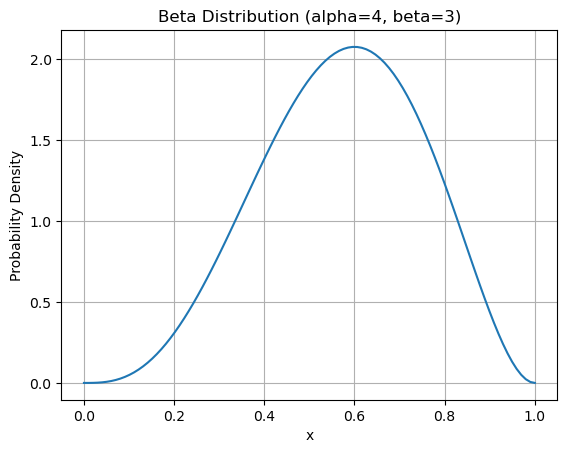

In [15]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# パラメータ
alpha = 4
beta = 3

# ベータ分布を生成するためのパラメータ
beta_dist = stats.beta(alpha, beta)
ls = np.linspace(0, 1, 100)

# プロット
plt.plot(ls, beta_dist.pdf(ls)) # pdf : Probability density function.
plt.title('Beta Distribution (alpha=4, beta=3)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

独立な一様分布$Y , U$を使って確率変数を次のように定義します．
$$
X = Y \ \ \ (c_0 U \leq f(Y)) \\
\ \ \ -1\ \ \ \ (otherwise)
$$
ただし，$f(Y) = \dfrac{Y^{a-1}(1-Y)^{b-1}}{B(a,b)}$であり，$B(a,b)$はベータ関数です．

また，$c_0$は$f(Y)$の最大値を表します．(問1)

そして，$Pr[(c_0 U \leq f(Y))] = \dfrac{1}{c_0}$ということがわかっています．(問2)

実際に，この確率変数$X$はベータ分布に従うことがわかります．(問3)

### 棄却法のアルゴリズム
1. 提案分布からサンプリングを行う．
2. $c_0 U \leq f(Y)$を満たすかどうかを判定する．
3. 満たさない場合は，1に戻る．
4. 満たす場合は，$X = Y$として，$X$を採用する．
5. 1に戻る．   

1つのサンプルを得るためには，期待値的に$2c_0$個の一様乱数を発生させる必要があります．（問4）

In [16]:
c0 = beta_dist.pdf(0.6)

In [17]:
# お試し実装
u = np.random.uniform(0, 1)
y = np.random.uniform(0, 1)

left = c0 * u
right = beta_dist.pdf(y)

if c0 * u <= beta_dist.pdf(y):
    print(left)
    print(right)
    print('Accept')
else:
    print(left)
    print(right)
    print('Reject')

1.1367571432048964
0.28202186113471456
Reject


In [18]:
# 関数として定義
def rejection_sampling(c0 , n_samples=1000):
    samples = []
    for i in range(n_samples):
        u = np.random.uniform(0, 1)
        y = np.random.uniform(0, 1)
        left = c0 * u
        right = beta_dist.pdf(y)
        if c0 * u <= beta_dist.pdf(y):
            samples.append(y)
    return samples

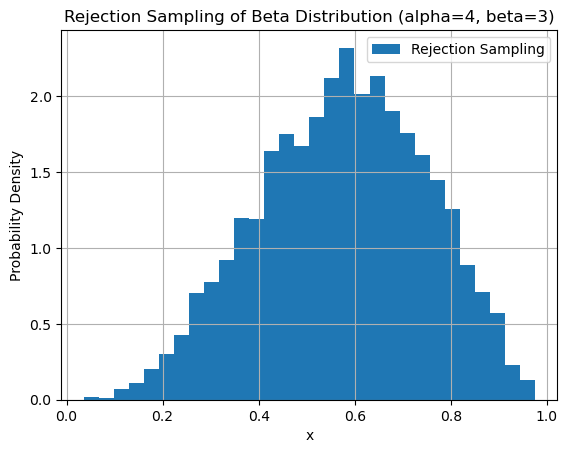

In [19]:
# サンプル数
n_samples = 10000

# 棄却サンプリングの実行
samples = rejection_sampling(c0 , n_samples)

# ヒストグラムのプロット
plt.hist(samples, bins=30, density=True, label='Rejection Sampling')
plt.title('Rejection Sampling of Beta Distribution (alpha=4, beta=3)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

採択される確率は$c_0^{-1}$であったので，確かめてみます．

In [20]:
1/c0 * n_samples

4822.530864197535

In [21]:
len(samples)

4778

### ボックス・マーラー変換
アクチュアリー数学2022問3

正規分布のサンプリング方法

逆関数法で正規分布をサンプリングすることはできません．

しかし，逆関数法で生成できる指数分布と，一様乱数の形状を変化させたものを組み合わせることで，正規分布をサンプリングすることができます．
$$
X = \sqrt{-2 \log U_1} \cos(2 \pi U_2) \\
Y = \sqrt{-2 \log U_1} \sin(2 \pi U_2)
$$

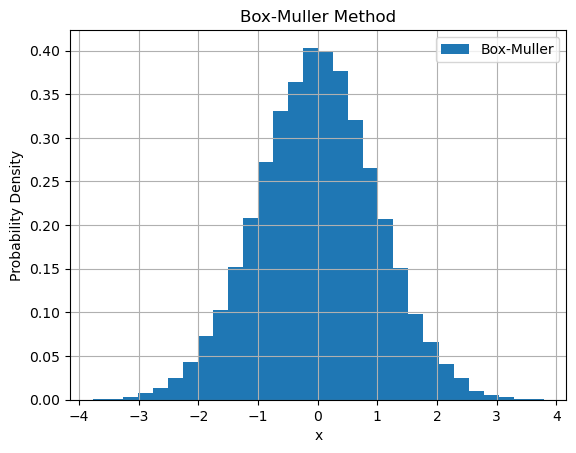

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# ボックス・マーラー法による正規乱数の生成
def box_muller(n_samples=1000):
    samples = []
    for i in range(n_samples):
        u1 = np.random.uniform(0, 1)
        u2 = np.random.uniform(0, 1)
        z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
        z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
        samples.append(z1)
        samples.append(z2)
    return samples

# サンプル数
n_samples = 10000

# ボックス・マーラー法の実行
samples = box_muller(n_samples)

# ヒストグラムのプロット
plt.hist(samples, bins=30, density=True, label='Box-Muller')
plt.title('Box-Muller Method')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

## 近似手法

### ラプラス近似
連続変数の集合上に定義されている確率変数関数に対して，ガウス分布による近似を見出すことを目的としています．

以下にラプラス近似の流れを説明します．

求めたい分布$p(\vec{x})$として
$$
p(\vec{x}) = \frac{1}{Z} f(\vec{x})
$$
と書けるとします．

まずはピークを見つけます．

つまり
$$
\frac{\partial p(\vec{x}_0)}{\partial \vec{x}} = 0
$$
を満たす$\vec{x}_0$を求めます．

次に，対数を取ってその$x_0$点周りでテイラー展開をします．
$$
\log p(\vec{x}) = \log p(\vec{x}_0) + \frac{1}{2}(\vec{x} - \vec{x}_0)^T \nabla \nabla \log p(\vec{x}_0) (\vec{x} - \vec{x}_0) + \cdots
$$

ここで，$\textbf{A} = - \nabla \nabla \log p(\vec{x}_0)$をヘッセ行列と定義します．

そのヘッセ行列を用いて以下のように近似をします．
$$
p(\vec{x}) \approx \frac{|\textbf{A}|^{1/2}}{2\pi^{M/2}} \exp \left( - \frac{1}{2} (\vec{x} - \vec{x}_0)^T \textbf{A} (\vec{x} - \vec{x}_0) \right)
$$


簡単な具体例を以下に示します．

範囲が$-\pi$から$\pi$の$\cos$関数をラプラス近似しましょう．

簡単な計算から標準正規分布となることがわかります．

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 範囲を定義
x = np.linspace(-np.pi, np.pi, 1000)

# cos関数
f = np.cos(x)

# cos関数の導関数
def df(x):
    return -np.sin(x)

# cos関数の二階導関数
def ddf(x):
    return -np.cos(x)

In [24]:
# ラプラス近似
# x_0は最大値の点（cos関数の場合は0）
x_0 = 0
laplace_approximation = np.cos(x_0) + df(x_0) * (x - x_0) + 0.5 * ddf(x_0) * (x - x_0)**2

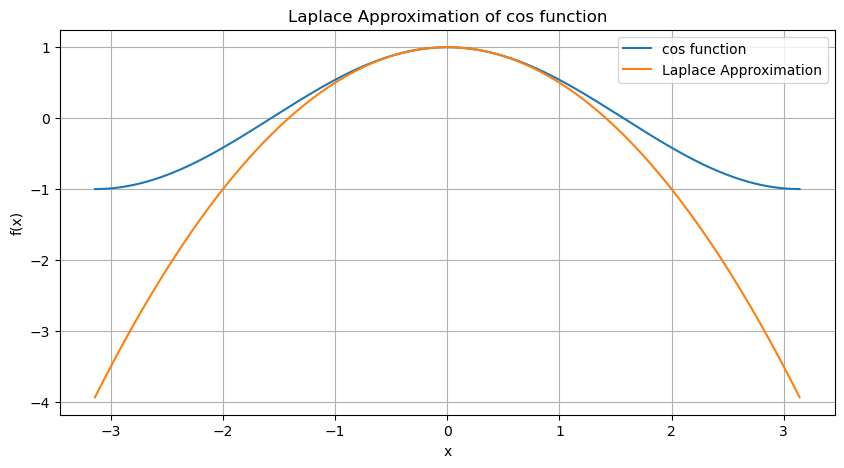

In [25]:
# グラフ描画
plt.figure(figsize=(10, 5))
plt.plot(x, f, label='cos function')
plt.plot(x, laplace_approximation, label='Laplace Approximation')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Laplace Approximation of cos function')
plt.grid(True)
plt.show()

ピーク付近で良い近似になっていることがわかります．

### MCMC法
#### 単純モンテカルロ法
モンテカルロ法は，乱数を用いて積分や和を求める計算手法です．

物理現象に関する乱数発生規則は，ボルツマン分布に従うということから
$$
P[C] = \frac{1}{Z} e^{-\beta E[C]}
$$
で与えられます．

この発生規則に対する何らかの関数の期待値を求めたいとします．
$$
\langle f \rangle = \sum_C f[C] P[C]
$$

これを近似的に計算するために，以下のような方法を考えます．
$$
\langle f \rangle \simeq \frac{1}{N} \sum^{N}_{i=1} f[C_i]
$$

この規則から乱数を発生させれば良いのですが，やはり分配関数の計算が大変です．

そこで分配関数を直接計算せずに，シミュレーションを行える方法が次に説明するマルコフ連鎖モンテカルロ法です．

#### MCMC法
マルコフ連鎖モンテカルロ法は，マルコフ連鎖を用いて，分配関数を計算せずにシミュレーションを行う方法です．

マルコフ連鎖とは，ある状態から別の状態に遷移する確率が，その状態のみに依存するような確率過程のことです．
$$
P[C_{t+1} | C_t, C_{t-1}, \cdots, C_0] = P[C_{t+1} | C_t]
$$

また，次の式が成り立つとき，分布$p_*[C]$を定常分布と呼びます．
$$
\sum_{C'} p_*[C'] P[C | C'] = p_*[C]
$$

定常分布がサンプルを取り出したい事後分布として，その定常分布に収束するような推移確率$ P[C_{t+1}|C_t]$を設計するのがマルコフ連鎖モンテカルロ法アイディアです．

$p_*[C]$が定常分布となるための十分条件として，以下の詳細釣り合い条件があります．
$$
p_*[C] P[C'|C] = p_*[C'] P[C|C']
$$

この式を$C'$で総和を取ると定常分布の定義式になります．

#### MH法
有名なMCMC法としてMetropolis-Hastings法があります．

基本的な手順は以下の通りです．

$p(x)\propto \hat{p}(x)$となるような正規化されていない関数がわかっているとします．

#### 1.初期化: 
マルコフ連鎖の初期状態を選びます．

#### 2.遷移カーネルの選択: 
提案分布 (proposal distribution) または遷移カーネルを選択します．提案分布で用いられるのは，一般的に正規分布や一様分布です。

以下で提案分布$q(x|x^{\prime})$と書きます．

#### 3.反復: 
以下の手順を多数回（N回）繰り返します．

a. サンプルの提案: 遷移カーネルを使用して，現在の状態から新しい状態を提案します．

b. 受理確率の計算: 提案されたサンプル$ x^{\prime}$に対して、受理確率 $ r $を計算します。これは、以下の式で計算されます。
$$
r =  \frac{\hat{p}(x')  q(x'| x) }{ \hat{p}(x)  q(x| x'))} 
$$

c. サンプルの受理または棄却: 受理確率を使った以下の確率を用いて，提案されたサンプルを受理または棄却します．
$$
\min\left\{ 1,\frac{\hat{p}(x')  q(x'| x) }{ \hat{p}(x)  q(x| x'))} \right\}
$$
$x'$を新しい状態として受理します．そうでなければ，$x$を新しい状態として保持します．

#### 4.出力: 
N回の反復を終えたら,生成されたサンプルの系列を出力します.初期のいくつかのサンプルは,マルコフ連鎖が定常分布に収束するまでの「バーンイン」期間として捨てることがよくあります.

In [26]:
import numpy as np
from scipy.stats import norm

# データの生成
X = np.arange(0, 5, 0.2)
Y = np.arange(0, 5, 0.2)
noise = np.random.normal(0, 0.5, len(X))
Y = X + noise

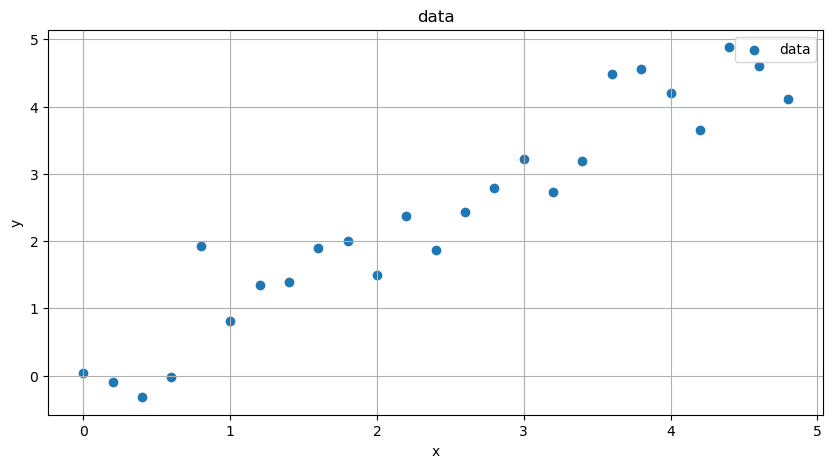

In [27]:
# データのプロット
plt.figure(figsize=(10, 5))
plt.scatter(X, Y, label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('data')
plt.grid(True)
plt.show()

/tmp/ipykernel_2213236/1789056702.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, step=step, tune=1000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_2213236/1789056702.py:20: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


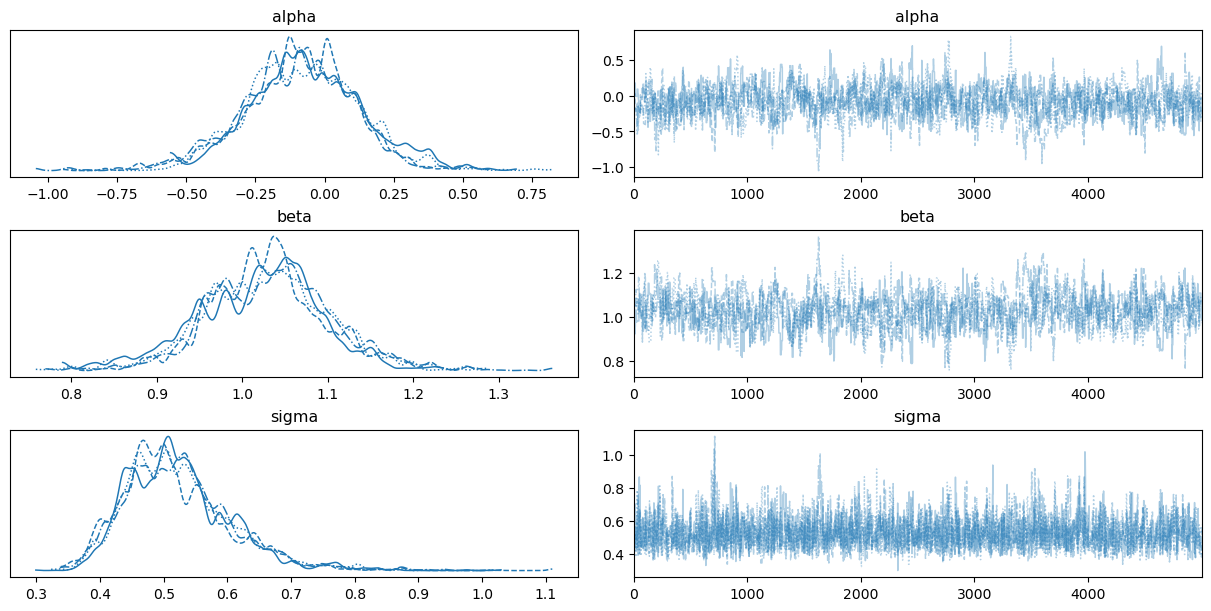

In [28]:
# PyMC3モデルを定義
import pymc3 as pm
with pm.Model() as model:
    # 事前分布を定義
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # 線形関係
    mu = alpha + beta * X

    # 尤度関数を定義
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

    # Metropolis-Hastingsサンプラーを用いてサンプリング
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, tune=1000)

# 結果のプロット
pm.traceplot(trace)
plt.show()

/home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

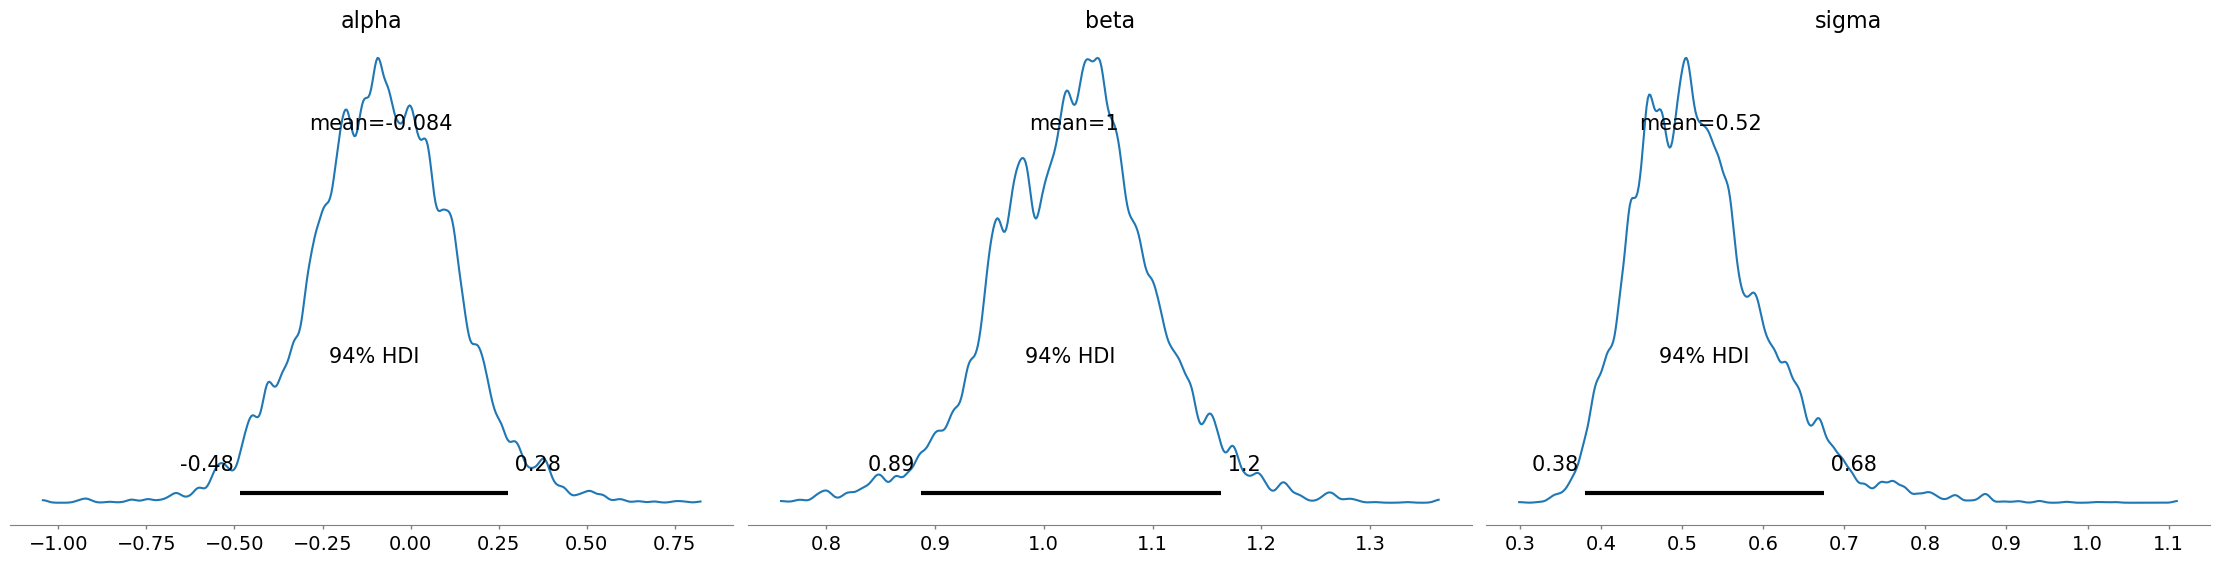

In [29]:
# 事後分布の表示
pm.plot_posterior(trace)

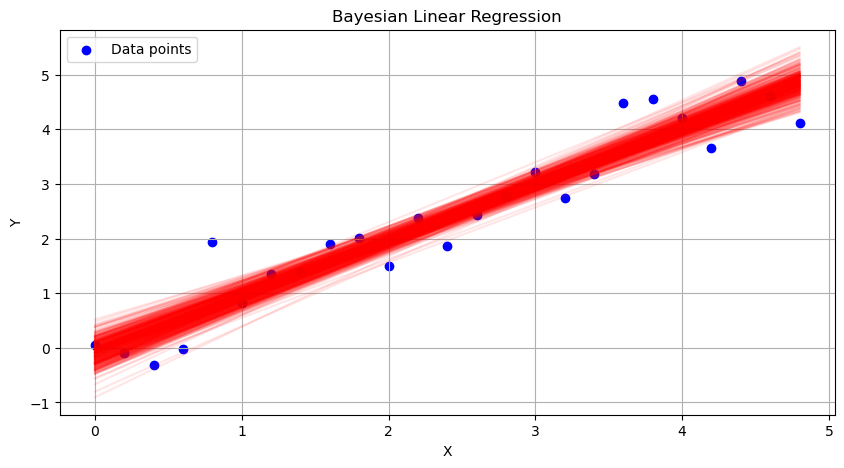

In [30]:
# 事後分布からサンプルされたパラメータを使用して回帰直線を生成
alpha_samples = trace['alpha']
beta_samples = trace['beta']

plt.figure(figsize=(10, 5))

# データ点をプロット
plt.scatter(X, Y, c='blue', label='Data points')

# 事後分布からのパラメータサンプルを使って複数の回帰直線をプロット
for i in range(0, len(alpha_samples), 50):
    plt.plot(X, alpha_samples[i] + beta_samples[i] * X, c='red', alpha=0.1)

# プロットの装飾
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayesian Linear Regression')
plt.legend()
plt.grid(True)

# プロットを表示
plt.show()

推定した事後分布から50本の可能な直線を引きました．

#### EP法
期待値伝播法のステップ

##### 1.初期化: 
事後分布の近似$q(w)$を適当な分布で初期化します。

#### 2.分布の分解: 
事後分布$p(w | \text{data})$は、データ点ごとの因子の積に分解できます。つまり、$p(w | \text{data}) \propto p(w) \prod_{i=1}^{N} f_i(w)$です。ここで$f_i(w)$は各データ点$(x_i, y_i)$に関連する因子です。

#### 3.近似因子の更新:
各因子$f_i(w)$について、以下の手順を繰り返します:

a. キャビティ分布の計算: 事後分布から$i$番目の因子を除いた分布を計算します。これをキャビティ分布と呼び、$q_{-i}(w) = \frac{q(w)}{f_i(w)}$で定義されます。

b. 仮分布の計算: キャビティ分布に$i$番目の因子を掛け合わせて、$q_i^{\text{new}}(w) \propto q_{-i}(w) f_i(w)$を計算します。

c. 近似因子の更新: $f_i(w)$を更新するために、$q_i^{\text{new}}(w)$を簡易な分布に近似します。例えば、ガウス分布で近似する場合、$q_i^{\text{new}}(w)$の平均と分散を計算して、新しい$f_i(w)$とします。

d. 近似事後分布の更新: 最後に$q(w)$を更新します。$q(w) \propto q_{-i}(w) \times f_i^{\text{new}}(w)$となります。

#### 4.収束: 
近似因子が十分収束するまで、ステップ3を繰り返します。

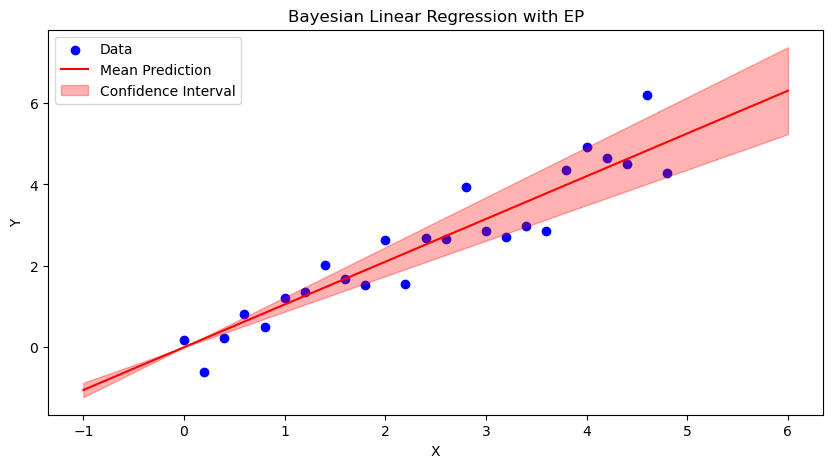

In [31]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

# データの生成
X = np.arange(0, 5, 0.2).reshape(-1, 1)
Y = np.arange(0, 5, 0.2).reshape(-1, 1)
noise = np.random.normal(0, 0.5, len(X)).reshape(-1, 1)
Y = X + noise

# ガウス過程の定義
kernel = GPy.kern.Linear(1) + GPy.kern.Bias(1)  # Bias kernelを追加してみる
model = GPy.models.GPRegression(X, Y, kernel)

# EP法で近似
model.inference_method = GPy.inference.latent_function_inference.expectation_propagation.EP()

# ジッターを追加
model.optimize_restarts(num_restarts=3, verbose=False, robust=True) # 再開回数を少なくしてみる

# 予測
X_pred = np.linspace(-1, 6, 100).reshape(-1, 1)
mean, variance = model.predict(X_pred)

# 結果のプロット
plt.figure(figsize=(10, 5))
plt.scatter(X, Y, c='b', label='Data')
plt.plot(X_pred, mean, c='r', label='Mean Prediction')
plt.fill_between(X_pred.flatten(), (mean - 2 * np.sqrt(variance)).flatten(), (mean + 2 * np.sqrt(variance)).flatten(), color='r', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayesian Linear Regression with EP')
plt.show()

### 変分推論

#### 1.近似分布族の選択: 
まず、事後分布 $p(z|x)$ を近似するための分布族 $q(z;\lambda)$ を選びます。ここで、$z$ は潜在変数、$x$ は観測データ、$\lambda$ は近似分布のパラメータです。ガウス分布や平均場近似（各潜在変数が独立であると仮定）などがよく使われます。
#### 2.目的関数の定義: 
変分推論では、近似分布 $q(z;\lambda)$ が真の事後分布 $p(z|x)$ に近くなるようにパラメータ $\lambda$ を選びます。これは、KLダイバージェンスなどを用いて測ることができます。しかし、一般に、変分下限（Evidence Lower BOund; ELBO）と呼ばれる量を最大化する方法が一般的です。ELBOは以下で定義されます。
$$
\text{ELBO}(\lambda) = \mathbb{E}_{q(z;\lambda)}[\log p(x,z)] - \mathbb{E}_{q(z;\lambda)}[\log q(z;\lambda)]
$$
#### 3.最適化:
ELBOを最大化するようなパラメータ $\lambda$ を求めます。これは、勾配上昇法やその他の最適化アルゴリズムを使用して行います。パラメータの更新は、以下のようになります。
$$
\lambda^{(t+1)} = \lambda^{(t)} + \eta \nabla_{\lambda} \text{ELBO}(\lambda^{(t)})
$$
#### 4.近似事後分布の使用: 
$\lambda$ が収束したら、$q(z;\lambda)$ を事後分布の近似として使用します。これを使って、事後予測分布を計算するなど、ベイズモデルの解析を行います。

Finished [100%]: Average Loss = 34.696
 /home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
 /home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


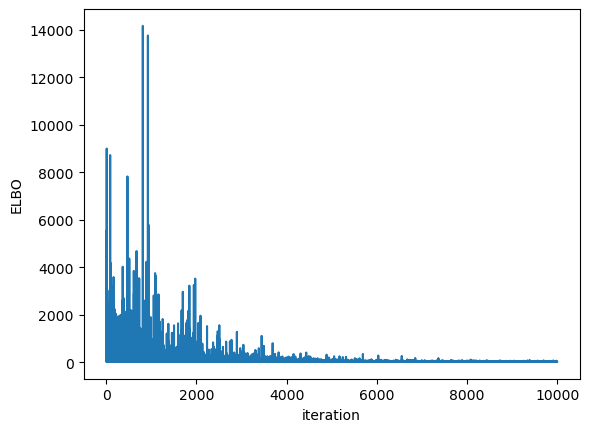

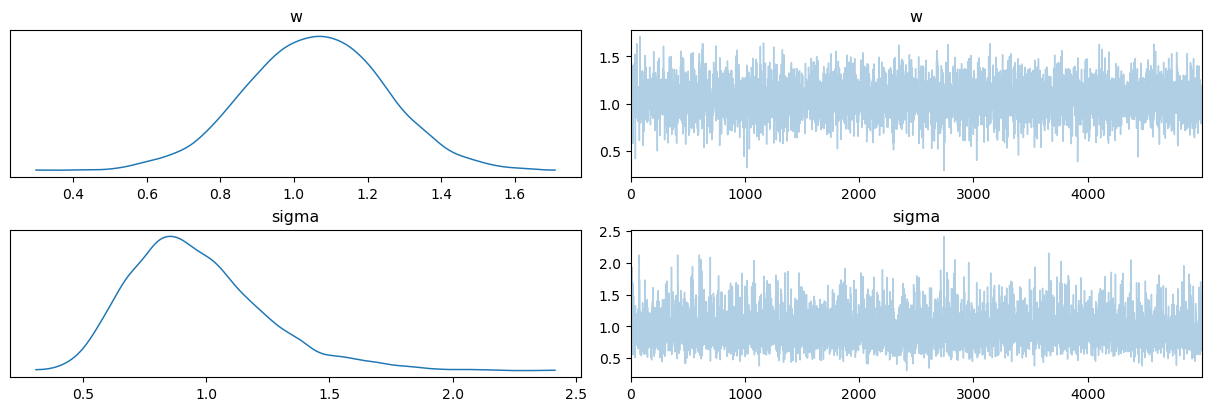

In [32]:
import pymc3 as pm

# モデルの構築
with pm.Model() as model:
    # 事前分布
    w = pm.Normal('w', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # 尤度
    likelihood = pm.Normal('y', mu=w * X, sigma=sigma, observed=Y)
    
    # 変分推論で事後分布を近似
    approx = pm.fit(n=10000, method='advi')
    
# 推論結果のプロット
plt.plot(approx.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')

# サンプリング
trace = approx.sample(5000)

# 事後分布の要約
pm.summary(trace)

# 事後分布のプロット
pm.traceplot(trace)

plt.show()

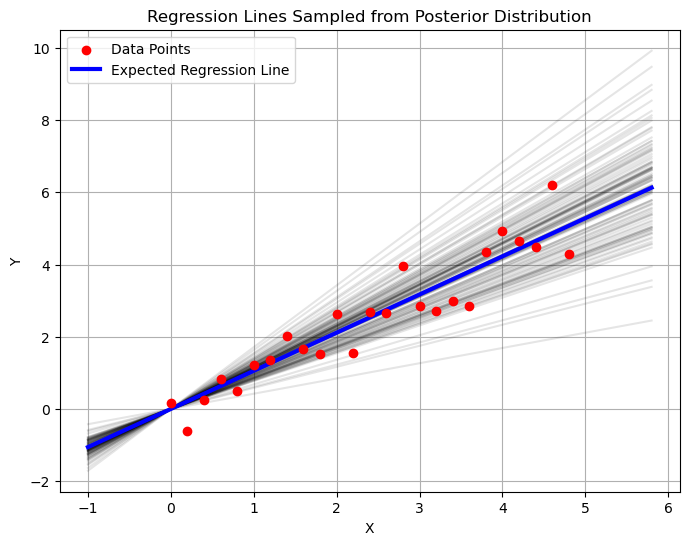

In [33]:
# 事後分布からサンプリングした回帰直線をプロット
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c='red', zorder=10, label='Data Points')
x_values = np.linspace(min(X)-1, max(X)+1, 100)

# サンプリングした重みwを使って回帰直線をプロット
for w_sample in trace['w'][:100]: # 100サンプルだけプロットしてみる
    plt.plot(x_values, w_sample * x_values, 'k-', alpha=0.1)

# 事後分布の期待値に関する回帰直線をプロット
mean_w = np.mean(trace['w'])  # wのサンプルの平均値を計算
plt.plot(x_values, mean_w * x_values, 'b-', lw=3, label='Expected Regression Line')


# グラフ設定
plt.title('Regression Lines Sampled from Posterior Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

サンプリングされた重み $w$ を使用して、期待値を採用したときの予測直線と事後分布から100本の回帰直線をプロットしています。